# **Phase 1 - Analysing GoEmotions and VAD Mapping**

## GoEmotions DataSet

*   [GoEmotions @ Google's github](https://github.com/google-research/google-research/tree/master/goemotions/data)




In [ ]:
# Set working directory as the project's dir
from google.colab import drive
drive.mount('/content/drive/')

# Change here to the path in Google Drive where this projcet is located
%cd "drive"/"My Drive"/"NLP Project"/"emotion-recognition-nlp-project"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/NLP Project/emotion-recognition-nlp-project


In [ ]:
# Packages
!pip3 install datasets transformers -q
!pip3 install torch

In [ ]:
# Imports
import pandas as pd

In [ ]:
# Load split GoEmotions to pandas DFs
from datasets import load_dataset
go_emotions = load_dataset("go_emotions", "simplified")
data = go_emotions.data
train, dev, test = data["train"].to_pandas(), data["validation"].to_pandas(), data["test"].to_pandas()

Reusing dataset go_emotions (/root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Adding verbal emotions column
EMOTIONS_PATH = "data/goemotions/emotions.txt"
emotions_file = open(EMOTIONS_PATH, "r")
labels_list = emotions_file.read().splitlines()

idx2emotion = {i : e for i, e in enumerate(labels_list)}
emotion2idx = None # TODO reverse the dict

train["emotions"] = train["labels"].apply(lambda labels: [idx2emotion[i] for i in labels])
dev["emotions"] = dev["labels"].apply(lambda labels: [idx2emotion[i] for i in labels])
test["emotions"] = test["labels"].apply(lambda labels: [idx2emotion[i] for i in labels])


## Delete multi-labels from datasets

We shall temporarily ignore multi-labaled exmaple just for simplicity. Later we will choose a way to treat them

There might be another way of doing it, as @Shir said.

In [ ]:
# Add label counts column
train['labels_count'] = train['labels'].apply(lambda labels: len(labels))
dev['labels_count'] = dev['labels'].apply(lambda labels: len(labels))
test['labels_count'] = test['labels'].apply(lambda labels: len(labels))

# Print percenrage of multi-labels (candidates to delete)
print("--- What is the part that will be delete? --")
print("train : ", sum(train['labels_count'] > 1) / len(train['labels_count']))
print("dev : ", sum(dev['labels_count'] > 1) / len(dev['labels_count']))
print("test : ", sum(test['labels_count'] > 1) / len(test['labels_count']))

--- What is the part that will be delete? --
train :  0.16360285648468095
dev :  0.1618134906008109
test :  0.15422885572139303


In [ ]:
train_one_label = train[train['labels_count'] == 1]
dev_one_label = dev[dev['labels_count'] == 1]
test_one_label = test[test['labels_count'] == 1]

## Map to VAD
We'd like to map each example to VAD, using its label (= emotion).
Each lexicon's df will have the column `word`, `v`, `a`, `d`

1. **First option** - [NRC-VAD : 2018](http://saifmohammad.com/WebPages/nrc-vad.html)
Crowd sourced lexicon, mapping 20K words to VAD.

In [ ]:
NRC_VAD_LEXICON_PATH = "data/mapping-emotions-to-vad/nrc-vad/NRC-VAD-Lexicon.txt"
df_nrc = pd.read_csv(NRC_VAD_LEXICON_PATH, sep="\t", 
                     names=['word', 'v', 'a', 'd'])

# desired mapping from NRC
mapping_nrc = df_nrc[df_nrc["word"].apply(lambda word: word in labels_list)]
mapping_nrc.head()
# len(mapping_nrc) = 28

,word,v,a,d
251,admiration,0.969,0.583,0.726
624,amusement,0.929,0.837,0.803
670,anger,0.167,0.865,0.657
709,annoyance,0.167,0.718,0.342
865,approval,0.854,0.460,0.889


2. **Second option** - [ANEW : 1999](https://pdodds.w3.uvm.edu/teaching/courses/2009-08UVM-300/docs/others/everything/bradley1999a.pdf)
Psychology students sourced lexicon, mapping 1K words to VAD.

In [ ]:
ANEW_LEXICON_PATH = "data/mapping-emotions-to-vad/anew/all.csv"
df_anew_raw = pd.read_csv(ANEW_LEXICON_PATH, sep=",")

# mapping to conventioned dateframe
_mapper = {
    "Description": "word",
    "Valence Mean": "v",
    "Arousal Mean": "a",
    "Dominance Mean": "d",
}
_scaler = lambda x: (x - 1) / 8  # linear scaling:  [1,9] --> [0,1] 
# We can try different scalings and see if we get better results (but the current one is the most netural)

df_anew = df_anew_raw[_mapper.keys()].rename(_mapper, axis=1)
df_anew[["v", "a", "d"]] = df_anew[["v", "a", "d"]].apply(_scaler)

# desired mapping from ANEW
mapping_anew = df_anew[df_anew["word"].apply(lambda word: word in labels_list)]
mapping_anew.head()
# NOTICE: len(mapping_anew) = 9

,word,v,a,d
142,joy,0.95000,0.77750,0.66000
172,love,0.96500,0.68000,0.76375
308,optimism,0.74375,0.54250,0.70125
360,pride,0.75000,0.60375,0.75750
714,anger,0.16750,0.82875,0.56250


3. **Third option** - [Warriner, A.B., Kuperman, V., & Brysbaert, M. : 2013](http://crr.ugent.be/papers/Warriner_et_al_affective_ratings.pdf)
Crowd sourced lexicon that extends ANEW, mapping 14K words to VAD.

In [ ]:
WARRINER_LEXICON_PATH = "data/mapping-emotions-to-vad/Warriner-et-al/Ratings_Warriner_et_al.csv"
df_warriner_raw = pd.read_csv(WARRINER_LEXICON_PATH, sep=",")

# mapping to conventioned dateframe
_mapper = {
    "Word": "word",
    "V.Mean.Sum": "v",
    "A.Mean.Sum": "a",
    "D.Mean.Sum": "d",
}
# NOTE: we can try vad ratings of a specific group- .M = male; .F = female; .O = older; .Y = younger; .H = high education; .L = low education

_scaler = lambda x: (x - 1) / 8  # linear scaling:  [1,9] --> [0,1] 
# We can try different scalings and see if we get better results (but the current one is the most netural)

df_warriner = df_warriner_raw[_mapper.keys()].rename(_mapper, axis=1)
df_warriner[["v", "a", "d"]] = df_warriner[["v", "a", "d"]].apply(_scaler)

# desired mapping from Warriner
mapping_warriner = df_warriner[df_warriner["word"].apply(lambda word: word in labels_list)]
mapping_warriner.head()
# len(mapping_warriner) = 27

,word,v,a,d
151,admiration,0.82250,0.56500,0.63875
386,amusement,0.75000,0.47750,0.69875
417,anger,0.18750,0.61625,0.51750
441,annoyance,0.24375,0.38750,0.30625
540,approval,0.71875,0.31500,0.70375


In [ ]:
vad_mappings = {"NRC":mapping_nrc, "Anew":mapping_anew, "Warriner":mapping_warriner}

In [ ]:
def get_missing_emotions(mapping):
  return [emo for emo in labels_list if emo not in list(mapping["word"])]

print("--- Which emotions are missing ? --")
for mapping_name, mapping in vad_mappings.items():
  print(f"{mapping_name}: {', '.join(get_missing_emotions(mapping))}")

--- Which emotions are missing ? --
NRC: 
Anew: admiration, amusement, annoyance, approval, caring, confusion, curiosity, disappointment, disapproval, disgust, embarrassment, gratitude, nervousness, realization, relief, remorse, sadness, surprise, neutral
Warriner: caring


# Visualize VAD mapping

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(mapping, mapping_name):
  """
  mapping - DataFrame
  mapping.columns = 'word', 'v', 'a', 'd'
  """

  v = mapping['v'].tolist()
  a = mapping['a'].tolist()
  d = mapping['d'].tolist()

  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  ax.scatter(v, a, d)

  ax.set_xlabel('valence')
  ax.set_ylabel('arousal')
  ax.set_zlabel('dominance')

  description = f"{mapping_name} VAD mapping"
  plt.figtext(0.5, 0.01, description, ha='center', va= 'top', fontsize=16)


  plt.show()



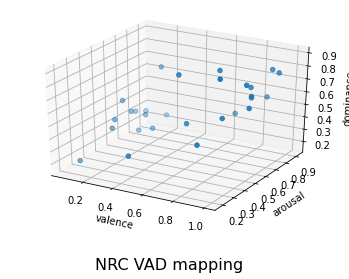

In [ ]:
visualize(mapping_nrc, "NRC")

In [ ]:
# TODO: change dataframes indexes of mapping_anew, mapping_nrc, mapping_warriner to GoEmotions indices (like the indexes in labels_list)

# Primitive Regression Approaches
Here we shall try some naive models as a baseline, before "dropping the hammer" with fine-tuning.

We shall use bert's output's as embeddings.

In [ ]:
# get BERT
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bertModel = AutoModel.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# BERT tokenizing
def bert_tokenizer(sent):
  """
     tokenize the given sentence into pytorch tensotr
     (just like Bert does in its input layer)
  """
  tokenized_sentence = tokenizer(sent, return_tensors='pt')
  # tokenizer.tokenize(sent)  # subwords tokenization (first phase)
  # tokenizer.decode(tokenized_sentence["input_ids"]) # decode the full tokeniztion
  return tokenized_sentence

bert_tokenizer("just an exmaple we can enjoy from")

{'input_ids': tensor([[ 101, 1198, 1126, 4252, 1918, 7136, 1195, 1169, 5548, 1121,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
tokenizer.decode(((bert_tokenizer("just an exmaple we can enjoy from"))["input_ids"]).tolist()[0])

'[CLS] just an exmaple we can enjoy from [SEP]'

In [ ]:
# BERT forward pass
def bert_embedding_get_cls(tokenized_sent):
  """
    given a tokinized-sentence, perform bert's forward pass,
    returns the CLS 
  """
  bert_encoding = bertModel(**tokenized_sentence)

  bert_cls = bert_encoding.last_hidden_state[:, 0]  # original cls
  bert_cls_from_nsp = bert_encoding.pooler_output # cls after layers used in NSP task

  return bert_cls

### 1.1 - Linear regression approach
Although Linear Regression does **not** really model our task well, we'll try it as a baseline,
(We can also try to gradient a logistic regeression with cross entropy by our-self, if it's convex).

In [ ]:
from sklearn.linear_model import LinearRegression
def train_linear_regression_naive(X_train, Y_train):
  """
    trains a linear regression model on given data
  """
  regr_model = LinearRegression()
  regr.fit(X_train, Y_train)

  return regr


from sklearn.metrics import mean_squared_error, r2_score

def evaluate_linear_regression_model(regr_model, x_test, y_test):
  y_pred=regr_model.predict(X_test)

  print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
  print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

In [ ]:
# Regress VAD - TODO!

### 1.2 - NN regression approach
Practically we try logistic regression as well, BUT we add here non-linearity in the middle.

In [ ]:
from torch import nn

class RegresionNN(nn.Module):
    def __init__(self):
        super(RegresionNN, self).__init__()

        # my NN config
        self.in_dim = 768      # bert-encoding size
        self.hideen_dim = 500 
        self.out_dim = 3       # VAD dimension

        self.nn_stack = nn.Sequential(
            nn.Linear(self.in_dim, self.hideen_dim),
            nn.Sigmoid(),
            nn.Linear(self.hideen_dim, self.out_dim),
            nn.Sigmoid(),
        )

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.flatten(x)
        logits = self.nn_stack(x)
        return logits

In [ ]:
# TODO Use hugging-face trainer, for this regression ([Matan]: I am currently reading about it)

model = RegresionNN()
[p for p, _ in model.named_parameters()]

['nn_stack.0.weight',
 'nn_stack.0.bias',
 'nn_stack.2.weight',
 'nn_stack.2.bias']

### 1.3 - Probibilistic Models
Let's imagine we that VAD is disributed normally, for example (V | X) ~ N(mu, sigma), where V is valance and X is the sentence. 

Can we find a good model this way?